
Overview

Tasty Bytes is one of the largest food truck networks in the world with localized menu options spread across 30 major cities in 15 countries.
**Tasty Bytes is aiming to achieve 25% YoY sales growth over 5 years.**

As Tasty Bytes Data Scientists, we have been asked to support this goal by helping our food truck drivers more intelligently pick where to park for shifts.
**We want to direct our trucks to locations that are expected to have the highest sales on a given shift. This will maximize our daily revenue across our fleet of trucks.**

To provide this insight, we will use historical shift sales at each location to build a model. This data has been made available to us in Snowflake.
Our model will provide the predicted sales at each location for the upcoming shift.



#### **This is an introduction to Snowpark for Snowflake. We will use Snowpark to:**

- Explore the data
- Perform feature engineering
- Train a model
- Deploy the model in Snowflake

**Why Snowpark?**

- No copies or movement of data
- Maintain governance
- Leverage Snowflake scalable compute
- ...and more!





Let's get to know Snowpark. We will see that Snowpark makes it easy for Python users to leverage the Snowflake platform. Bringing these users into the Snowflake platform will foster collaboration and streamline architecture across all users and teams.



## Import Packages

After installing Snowpark in our Python environment, we import the Snowpark packages.
**Value:** Snowpark is easy to install and set up. It follows a familiar process for Python users.

_Documentation for installing and setting up Snowpark:_ [https://docs.snowflake.com/en/developer-guide/snowpark/python/setup.html](https://docs.snowflake.com/en/developer-guide/snowpark/python/setup.html)


Just like the Python packages we are importing, we will import the Snowpark modules that we need.
**Value**: Snowflake modules provide efficient ways to work with data and functions in Snowflake.



In [1]:
# Import Python packages
import pandas as pd
import json
import sys
import cachetools

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

Our Snowflake role, **hol_role**, can access the data in the **analytics** schema of the **hol_db** database. We will use the **hol_wh** warehouse that has been created by our sysadmin as a dedicated compute for data science workloads. 

We will use these parameters and our Snowflake account credentials to connect to Snowflake.



**Value:** Secure and governed.



In [2]:
import os, sys
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from utils import snowpark_utils
session = snowpark_utils.get_snowpark_session()

session.sql("SELECT CURRENT_ROLE()").show()

--------------------
|"CURRENT_ROLE()"  |
--------------------
|HOL_ROLE          |
--------------------



## Snowpark DataFrame

Let's create a Snowpark DataFrame containing our shift sales data from the **shift_sales** table in our Snowflake account using the Snowpark session.table function. A DataFrame is a data structure that contains rows and columns, similar to a SQL table.

Below, we'll run a DataFrame operation that with some aggregation and joins.  All of the functionality below is possible with SQL, but expressed in Python using a functional programming paradigm. 

**Value:** Familiar representation of data for Python users.



In [3]:
shift_sales_df = (
    session.table("hol_db.raw_pos.order_header")
       .select(F.col("shift_id"), "shift_start_time", "location_id", "order_total", "order_ts")
       .group_by("shift_id", "location_id")
       .agg(F.sum("order_total").alias("shift_sales"),
            F.iff(F.hour(F.min("shift_start_time")) < 12, "AM", "PM").alias("shift"),
            F.to_date(F.min("order_ts")).alias("date")
            )
       .join(session.table("hol_db.raw_pos.location").select("location_id", "city"), on="location_id")
       )       

# Write the DataFrame we just created
shift_sales_df.write.mode("overwrite").save_as_table("hol_db.analytics.shift_sales")


# Read that dataframe back from Snowflake
snowpark_df = session.table("hol_db.analytics.shift_sales")

## Preview the Data

With our Snowpark DataFrame defined, let’s use the .show() function to take a look at the first 10 rows.
**Value:** Instant access to data.



In [4]:
snowpark_df.show()

-------------------------------------------------------------------------------------
|"LOCATION_ID"  |"SHIFT_ID"  |"SHIFT_SALES"  |"SHIFT"  |"DATE"      |"CITY"         |
-------------------------------------------------------------------------------------
|15206.0        |200516528   |29842.0000     |AM       |2021-12-07  |New York City  |
|1888.0         |200516558   |13379.5000     |AM       |2021-12-09  |New York City  |
|4026.0         |200516559   |16511.5000     |PM       |2021-12-09  |New York City  |
|15191.0        |200516567   |31386.0000     |PM       |2021-12-09  |New York City  |
|3124.0         |200516573   |32073.0000     |PM       |2021-12-09  |New York City  |
|2863.0         |200516604   |29212.0000     |AM       |2021-12-11  |New York City  |
|2980.0         |200516690   |13482.0000     |AM       |2021-12-15  |New York City  |
|3008.0         |200516716   |25315.0000     |AM       |2021-12-16  |New York City  |
|15145.0        |200516772   |23799.0000     |AM      

## Select, Filter, Sort

Notice the Null values for "shift_sales". Let's look at a single location.

To do this, we will make another Snowpark DataFrame, location_df, from the above DataFrame and we will:

1. Select columns
2. Filter to a single location ID
3. Sort by date

**Value**: Efficient transformation pipelines using Python syntax and chained logic.



In [5]:
# Select
location_df = snowpark_df.select("date", "shift", "shift_sales", "location_id", "city")

# Filter
location_df = location_df.filter(F.col("location_id") == 1135)

# Sort
location_df = location_df.order_by(["date", "shift"], ascending=[0, 0])

# Display
location_df.show(n=20)

--------------------------------------------------------------------
|"DATE"      |"SHIFT"  |"SHIFT_SALES"  |"LOCATION_ID"  |"CITY"     |
--------------------------------------------------------------------
|2021-11-25  |AM       |5228.0000      |1135.0         |Vancouver  |
|2021-11-17  |PM       |10343.0000     |1135.0         |Vancouver  |
|2021-11-02  |PM       |3202.0000      |1135.0         |Vancouver  |
|2021-09-24  |AM       |5845.0000      |1135.0         |Vancouver  |
|2021-08-08  |PM       |7227.0000      |1135.0         |Vancouver  |
|2021-06-15  |AM       |3034.5000      |1135.0         |Vancouver  |
|2021-05-06  |PM       |9396.0000      |1135.0         |Vancouver  |
|2021-03-31  |PM       |7559.0000      |1135.0         |Vancouver  |
|2020-12-29  |PM       |9452.0000      |1135.0         |Vancouver  |
|2020-12-12  |AM       |6341.0000      |1135.0         |Vancouver  |
|2020-10-14  |PM       |9502.0000      |1135.0         |Vancouver  |
|2020-10-11  |AM       |7365.0000 

We can see that shift sales are populated 8 days prior to the latest date in the data. The **missing values** represent future dates that do not have shift sales yet.

## Snowpark works in two main ways:

1. Snowpark code translated and executed as SQL on Snowflake
2. Python functions deployed in a secure sandbox in Snowflake




## Explain the Query

Let's look at what was executed in Snowflake to create our location_df DataFrame. 

The translated SQL query can be seen in the Snowsight interface under _Activity_ in the _Query History_ or directly in our notebook by using the explain() function.

**Value:** Transparent execution and compute usage.



In [6]:
location_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT "DATE", "SHIFT", "SHIFT_SALES", "LOCATION_ID", "CITY" FROM hol_db.analytics.shift_sales WHERE ("LOCATION_ID" = 1135 :: INT) ORDER BY "DATE" DESC NULLS LAST, "SHIFT" DESC NULLS LAST
Logical Execution Plan:
GlobalStats:
    partitionsTotal=32
    partitionsAssigned=32
    bytesAssigned=3848704
Operations:
1:0     ->Result  SHIFT_SALES.DATE, SHIFT_SALES.SHIFT, SHIFT_SALES.SHIFT_SALES, SHIFT_SALES.LOCATION_ID, SHIFT_SALES.CITY  
1:1          ->Sort  SHIFT_SALES.DATE DESC NULLS LAST, SHIFT_SALES.SHIFT DESC NULLS LAST  
1:2               ->Filter  SHIFT_SALES.LOCATION_ID = 1135.0  
1:3                    ->TableScan  HOL_DB.ANALYTICS.SHIFT_SALES  LOCATION_ID, SHIFT_SALES, SHIFT, DATE, CITY  {partitionsTotal=32, partitionsAssigned=32, bytesAssigned=3848704}

--------------------------------------------


## Compare DataFrame Size

Let's bring a sample of our Snowflake dataset to our Python environment in a pandas DataFrame using the to_pandas() function. We will compare how much memory is used for the pandas DataFrame compared to the Snowpark DataFrame. As we will see, no memory is used for the Snowpark DataFrame in our Python environment. All data in the Snowpark DataFrame remains on Snowflake.


**Value:** No copies or movement of data when working with Snowpark DataFrames.



In [7]:
# Bring 10,000 rows from Snowflake to pandas
pandas_df = snowpark_df.limit(10000).to_pandas()

# Get Snowpark DataFrame size
snowpark_size = sys.getsizeof(snowpark_df) / (1024*1024)
print(f"Snowpark DataFrame Size (snowpark_df): {snowpark_size:.2f} MB")

# Get pandas DataFrame size
pandas_size = sys.getsizeof(pandas_df) / (1024*1024)
print(f"Pandas DataFrame Size (pandas_df): {pandas_size:.2f} MB")

Snowpark DataFrame Size (snowpark_df): 0.00 MB
Pandas DataFrame Size (pandas_df): 1.76 MB




Here we will use Snowpark to explore our data. A common pattern for exploration is to use Snowpark to manipulate our data and then bring an aggregate table to our Python environment for visualization.

**Value:**

- Native Snowflake performance and scale for aggregating large datasets.
- Easy transfer of aggregate data to the client-side environment for visualization.


As we explore our data, we will highlight what is being done in Snowflake and what we are transferring to our client-side environment (Python notebook environment) for visualization.



## How many rows are in our data?

This will give us an idea of how we might need to approach working with this data. Do we have enough data to build a meaningful model? What compute might be required? Will we need to sample the data?

**What's happening where?:** Rows counted in Snowflake. No data transfer.



In [8]:
snowpark_df.count()

265750

## Let's calculate some descriptive statistics.

We use the Snowpark describe() function to calculate summary statistics and then bring the aggregate results into a pandas DataFrame to visualize in a formatted table.

**What's happening where?:** Summary statistics calculated in Snowflake. Transfer aggregate summary statistics for client-side visualization.



In [9]:
snowpark_df.describe().to_pandas()

,SUMMARY,LOCATION_ID,SHIFT_ID,SHIFT_SALES,SHIFT,CITY
0,stddev,4254.386456,9.998458e+07,12195.016983,None,None
1,max,15517.000000,2.005747e+08,53863.500000,PM,Warsaw
2,count,265750.000000,2.657500e+05,265750.000000,265750,265750
3,min,1001.000000,5.766400e+04,95.000000,AM,Barcelona
4,mean,8089.203819,1.044954e+08,18932.100872,None,None


## What are the numeric columns?

We want to understand the data types in our data and how we might need to handle them in preparation for modeling. For numeric columns, this could include normalizing the data to the same scale or applying a transformation to change the distribution.

**What's happening where?:** The Snowflake table schema is used to get metadata information about the data. No data transfer.



In [10]:
# Define Snowflake numeric types
numeric_types = [T.DecimalType, T.DoubleType, T.FloatType, T.IntegerType, T.LongType]

# Get numeric columns
numeric_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in numeric_types]
numeric_columns

['LOCATION_ID', 'SHIFT_ID', 'SHIFT_SALES']

## What are the categorical columns?

Our model requires all features to be numeric. We want to identify columns that we will need to transform to a numeric representation if we would like to use them as features in our model.

**What's happening where?:** The Snowflake table schema is used to get metadata information about the data. No data transfer.



In [11]:
# Define Snowflake categorical types
categorical_types = [T.StringType]

# Get categorical columns
categorical_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in categorical_types]
categorical_columns

['SHIFT', 'CITY']

## What are the average shift sales (USD) by city?

Here, we are trying to understand what a "normal" shift sale looks like. What is the span of averages across cities? Are there any outlier cities that should be removed from our training data? Is there anything unexpected in the order of cities sorted by their average shift sales?

**What's happening where?:** Average sales by city calculated in Snowflake. Transfer city averages for client-side visualization.



<Axes: ylabel='CITY'>

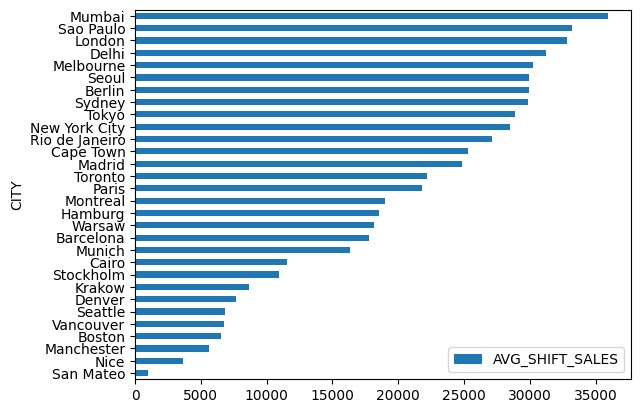

In [12]:
# Group by city and average shift sales
analysis_df = snowpark_df.group_by("city").agg(F.mean("shift_sales").alias("avg_shift_sales"))

# Sort by average shift sales
analysis_df = analysis_df.sort("avg_shift_sales", ascending=True)

analysis_df.schema
# Pull to pandas and plot
analysis_df.to_pandas().astype({'AVG_SHIFT_SALES': float}).plot.barh(x="CITY", y="AVG_SHIFT_SALES")


## Looking at Vancouver, how many locations are there?

We are going to use Vancouver, Canada as our test city when predicting the best location for future shifts. Let's get to know locations and shift sales in that city. First, we will see how many location options there are in Vancouver for a food truck to park.

**What's happening where?:** Data filtered, averages calculated by location, and locations counted in Snowflake. No data transfer.



In [13]:
# Filter to Vancouver
analysis_df = snowpark_df.filter(F.col("city") == "Vancouver")

# Group by location and average shift sales
analysis_df = analysis_df.group_by("location_id").agg(F.mean("shift_sales").alias("avg_shift_sales"))

# Get the location count
print("Vancouver location count:", analysis_df.count())

Vancouver location count: 435


## What is the distribution of average shift sales (USD) by location in Vancouver?

The x-axis represents average shift sales (USD) and the y-axis represents the count of locations with that average. Most locations have an average shift sales around 7000 USD. The low-end location average is closer to 6000 USD and the upper end is around 8000 USD. We will keep this in mind when evaluating predictions.

**What's happening where?:** Data filtered and averages calculated by locations in Snowflake. Transfer location averages for client-side visualization.
**Value:** Aggregate where the data is stored using native Snowflake performance and scale. Easy transfer of aggregate data to client-side applications.



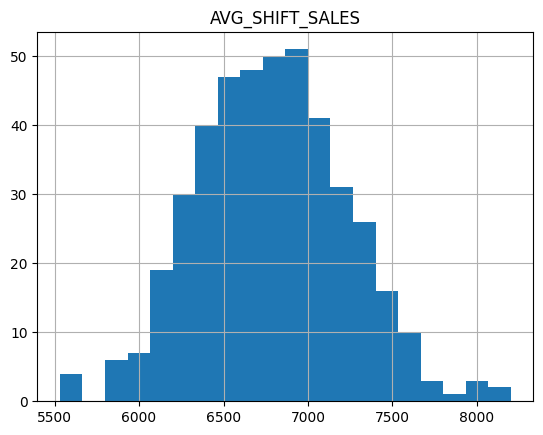

In [14]:
ax = analysis_df.to_pandas().astype({'AVG_SHIFT_SALES': float}).hist(column="AVG_SHIFT_SALES", bins=20)

<img src="/api/v1/file/e9006621-a0ba-49ba-8717-3d2cec9d1ae3" width="600" />




## Create a Rolling Average Feature

We will create a feature engineering pipeline by chaining transformations to prepare our data for model training.
**Value:** The Snowpark syntax makes pipelines easy to implement and understand. The syntax also allows for easy migration of Spark pipelines to Snowflake.
**All transformations for feature engineering in this notebook will be executed on Snowflake compute.**

Notice what we haven't had to do? No tuning, maintenance, or operational overhead. We just need a role, compute warehouse, and access to the data.
**Value**: Near-zero maintenance. Focus on the work that brings value.

## Create a Rolling Average Feature

We will use a Snowflake window function to get a **rolling shift average by location** over time. Window functions allow us to aggregate on a "moving" group of rows.

**Step 1. Create a Window**

Our window will partition the data by location and shift. It will order rows by date. It will include all rows prior to the current date of the observation it is aggregating for.



In [15]:
window_by_location_all_days = (
    Window.partition_by("location_id", "shift")
    .order_by("date")
    .rows_between(Window.UNBOUNDED_PRECEDING, Window.CURRENT_ROW - 1)
)

**Step 2. Aggregate across the Window**



In [16]:
snowpark_df = snowpark_df.with_column(
    "avg_location_shift_sales", 
    F.avg("shift_sales").over(window_by_location_all_days).astype(T.FloatType())
)

## Impute Missing Values

The rolling average feature we just created is missing if there are no prior shift sales at that location. We will replace those missing values with 0.



In [17]:
snowpark_df = snowpark_df.fillna(value=0., subset=["avg_location_shift_sales"])


## Encode Categorical Columns

Categorical columns need to be represented as numeric in our model. We will use binary encoding for the **shift** column by replacing:

- "AM" with 1
- "PM" with 0



In [18]:
snowpark_df = snowpark_df.with_column("shift", F.iff(F.col("shift") == "AM", 1, 0))

## Filter to Historical Data

Our data includes placeholders for future data with missing shift sales. The **future data** represents the next 7 days of shifts for all locations. The **historical data** has shift sales for all locations where a food truck parked during a shift. We will only use historical data when training our model and will filter out the dates where the **shift_sales** column is missing.



In [19]:
historical_snowpark_df = snowpark_df.filter(F.col("shift_sales").is_not_null())

## Drop Columns

Drop ID columns that will not be used in the model.



In [20]:
historical_snowpark_df = historical_snowpark_df.drop("location_id", "city", "date")

## Split Data into Training and Testing

We will use 80% of the data for model training and 20% for testing.



In [21]:
session.sql("USE SCHEMA hol_db.analytics").collect()
train_snowpark_df, test_snowpark_df = historical_snowpark_df.randomSplit([0.8, 0.2])

## Save Tables in Snowflake

We will save our training and test datasets to the **analytics schema** in our Snowflake account.

**Value:** Eliminate redundant data processing. These tables can be re-used to train more models beyond what we are training today.



In [22]:
# Save training data
train_snowpark_df.write.mode("overwrite").save_as_table("hol_db.analytics.shift_sales_train")

# Save test data
test_snowpark_df.write.mode("overwrite").save_as_table("hol_db.analytics.shift_sales_test")



We will now use our training data to train a linear regression model on Snowflake.

Recall from above, the two main ways that Snowpark works:

1. Snowpark code translated and executed as SQL on Snowflake
2. Python functions deployed in a secure sandbox in Snowflake

We will be leveraging the deployment of Python functions into Snowflake for training and model deployment.

Here, we see a typical data science workflow. We are finished **preparing** our data and now move on to **training in a Python stored procedure on Snowflake**. The model created from this stored procedure will be our tool for automating decisions around truck locations to maximize our revenue. We'll surface the predicted sales (model inference) on future data using a **Python user-defined function** to drive the decisions.

**Snowflake Stored Procedures** work well for training because they can read data, hold an entire table in memory to find patterns, and write files (e.g. model files) back to the Snowflake database.

**Snowflake User-Defined Functions** work well for inference because they return a single value for each row passed to the user-defined function. Because of this, they can easily be distributed to provide fast results.

**Value**: Effortless, scalable, and secure processing **without data movement** across compute environments.



## Create a Stage

We will use this stage to host user-defined functions, stored procedures, and model files on Snowflake.



In [23]:
# Create stage
session.sql("CREATE STAGE IF NOT EXISTS hol_db.analytics.model_stage").collect()

[Row(status='Stage area MODEL_STAGE successfully created.')]

## Create a Stored Procedure for Model Training

**Step 1. Create a Function for Training a Model**
This function trains a Scikit-learn linear regression model and saves the model to a stage. Linear regression finds a line that best fits the data points used in training. We then use that line as an estimation of where output values will be for future scenarios.

Here, training will use historical shift sales and features in our data to predict future shift sales of locations where our food trucks can park.

- **Inputs:**, Training table name on Snowflake, feature column names, target column names, file name for the saved model
- **Outputs:**, Feature weights of the trained model ,_(or feature contributions to the predicted value)_



In [24]:
def train_linreg(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
) -> T.Variant:

    # Import packages
    from sklearn.linear_model import LinearRegression
    from joblib import dump

    # Get training data
    df = session.table(training_table).to_pandas()

    # Set inputs X and outputs y
    X = df[feature_cols]
    y = df[target_col]

    # Train model
    model = LinearRegression().fit(X, y)

    # Get feature weights
    feature_weights = pd.DataFrame({"Feature": model.feature_names_in_, "Weight": model.coef_}).to_dict()

    # Save model
    dump(model, "/tmp/" + model_name)
    session.file.put(
        "/tmp/" + model_name,
        "@MODEL_STAGE",
        auto_compress=False,
        overwrite=True
    )

    # Return feature contributions
    return feature_weights


**Step 2. Register the Function on Snowflake**
To register the function on Snowflake as a stored procedure, specify what Python packages are required in the function. Here we specify:

- Snowpark
- Scikit-learn (for training our model)
- Joblib (for creating a model file)

Scikit-learn is a popular Python library for Machine Learning. We will be able to leverage its functionality in Snowflake in our deployed stored procedure.

**Value:** Easy access to hundreds of Python packages with automated dependency management.
_Python packages available in Snowflake:_ [https://repo.anaconda.com/pkgs/snowflake/](https://repo.anaconda.com/pkgs/snowflake/)



In [25]:
train_linreg_snowflake = session.sproc.register(
    func=train_linreg,
    name="hol_db.analytics.sproc_train_linreg",
    is_permanent=True,
    replace=True,
    stage_location="@hol_db.analytics.MODEL_STAGE",
    packages=["snowflake-snowpark-python", "scikit-learn", "joblib"]
)


package scikit-learn is not installed in the local environmentYour UDF might not work when the package is installed on the server but not on your local environment.
package joblib is not installed in the local environmentYour UDF might not work when the package is installed on the server but not on your local environment.


## Model Training

We will now train our model on Snowflake using our stored procedure. If more memory was required, a Snowpark Optimized Warehouse could be used. In this case, a standard Snowflake warehouse is sufficient.

_Documentation for Snowpark Optimized Warehouses: _ [https://docs.snowflake.com/en/developer-guide/snowpark/python/python-snowpark-training-ml.html](https://docs.snowflake.com/en/developer-guide/snowpark/python/python-snowpark-training-ml.html) 

**Value:** Always access the compute you need - no bottlenecks!


**Call the Training Stored Procedure**

We will call our stored procedure and specify our training table location, feature and target columns, and our saved model name. This will perform model training in Snowflake.

**Value: **Secure - Python stored procedures and user-defined functions execute in highly secure sandboxed environments.



In [26]:
# Specify inputs
training_table = "hol_db.analytics.shift_sales_train"
feature_cols = train_snowpark_df.drop("shift_sales").columns
target_col = "SHIFT_SALES"
model_name = "linreg_location_sales_model.sav"

# Call the training stored procedure
feature_contributions = train_linreg_snowflake(
    session,
    training_table,
    feature_cols,
    target_col,
    model_name
)   

## Examine Feature Contributions

Our stored procedure returns the feature contributions. Here we can see which features have the largest impact on shift sales predictions. The prediction provided by the linear regression model is a summation of the feature values multiplied by their respective weights (plus an additional bias term). We can see that people are hungrier in the afternoon!
**Value**: Training in a stored procedure isn't a black-box process. We can return the insight we need (in this case, the feature weights) or write to a table in Snowflake.



In [27]:
pd.DataFrame(eval(feature_contributions)).sort_values(by="Weight")

,Feature,Weight
2,SHIFT,-1264.179386
0,SHIFT_ID,-0.000007
1,AVG_LOCATION_SHIFT_SALES,0.706366


## View the Saved Model

Let's make sure our model is saved to the stage on Snowflake. We will list the files on the stage and see when they were last modified.



In [28]:
pd.DataFrame(session.sql("LIST @MODEL_STAGE").collect())

,name,size,md5,last_modified
0,model_stage/linreg_location_sales_model.sav,880,f60d459475e24321707e4ad2c991e86a,"Tue, 16 May 2023 03:43:30 GMT"




We need to make our model available in a central location where it can be used by other users and teams.

- The application development team will need to integrate it with the truck driver app to surface recommendations.
- The analyst team will use it to benchmark and measure the impact on sales.
- As data scientists, we will want to monitor the performance and work to improve the model.

What better location to deploy the model, than with the data being used by these teams?
**Value:** Democratize access to models and predictions.

## Create a User-Defined Function for Model Inference

**Step 1. Create a Function for Model Inference**
This function loads the saved model and predicts shift sales from input features

- **Inputs:**, Features
- **Outputs:**, Predicted shift sales

Because we specified the input as a pandas DataFrame and output as a pandas Series, the user-defined function will **execute in batches** instead of one row at a time. In many cases, this reduces the overall execution time for the query calling the user-defined function.

We also use the Python library cachetools to cache the model that is returned from the load_model function. This ensures that the **model is loaded once** per user-defined function call, instead of for each row or batch in the data.

**Value:** Fast and efficient predictions.



In [29]:
# Function to load the model from file and cache the result
@cachetools.cached(cache={})
def load_model(filename):
    
    # Import packages
    import sys
    import os
    import joblib
    
    # Get the import directory where the model file is stored
    import_dir = sys._xoptions.get("snowflake_import_directory")
    
    # Get the import directory where the model file is stored
    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Function to predict shift sales
def linreg_predict_location_sales(X: pd.DataFrame) -> pd.Series:
    
    # Load the model
    model = load_model("linreg_location_sales_model.sav")

    # Get predictions
    predictions = model.predict(X)

    # Return rounded predictions
    return predictions.round(2)

**Step 2. Register the Function on Snowflake**
To register the function on Snowflake as a user-defined function, we specify the Python packages required. Here we specify:

- Scikit-learn (for making predictions)
- Joblib (for loading the model from file)
- Cachetools (for caching the loaded model)

Additionally, we specify which files to import with the user-defined function. Here we specify our trained model file as an import.

**Value:** Simple and painless model deployment.



In [30]:
session.udf.register(
    func=linreg_predict_location_sales,
    name="udf_linreg_predict_location_sales",
    stage_location="@MODEL_STAGE",
    input_types=[T.FloatType()] * len(feature_cols),
    return_type=T.FloatType(),
    replace=True,
    is_permanent=True,
    imports=["@MODEL_STAGE/linreg_location_sales_model.sav"],
    packages=["scikit-learn", "joblib", "cachetools"]
)

package scikit-learn is not installed in the local environmentYour UDF might not work when the package is installed on the server but not on your local environment.
package joblib is not installed in the local environmentYour UDF might not work when the package is installed on the server but not on your local environment.
The version of package cachetools in the local environment is 5.3.0, which does not fit the criteria for the requirement cachetools. Your UDF might not work when the package version is different between the server and your local environment


## Predict!

Now that our inference user-defined function is deployed, we can use it in Snowflake on our data to get shift sales predictions.

**Scale Up Snowflake Compute**

We can perform distributed model inferencing across the nodes of our Snowflake warehouse by scaling up to a multi-node warehouse. By scaling up to a medium warehouse, the processing will distribute across all four warehouse nodes instead of using single-threaded execution on an x-small warehouse with 1 node. 

We haven't required a medium warehouse up to this point but can easily adjust our warehouse now to meet the compute requirements for this portion of our workflow.

**Value:** Cost-effective performance by adapting processing to machine learning needs.



In [31]:
session.sql("ALTER WAREHOUSE hol_wh SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

**Call the Inference Function**



In [32]:
train_pred = train_snowpark_df.select(
    "shift_sales",
    F.call_udf("udf_linreg_predict_location_sales", [F.col(c) for c in feature_cols]).alias("prediction")
)
train_pred.show()

--------------------------------
|"SHIFT_SALES"  |"PREDICTION"  |
--------------------------------
|16189.0000     |8547.75       |
|37761.0000     |23042.0       |
|5754.0000      |8547.86       |
|6543.0000      |12612.29      |
|7397.0000      |12890.95      |
|7592.5000      |13184.91      |
|7263.0000      |13366.41      |
|5424.0000      |13362.27      |
|30352.0000     |7057.94       |
|13705.0000     |28497.56      |
--------------------------------



## Evaluate

We will evaluate our model using Root-Mean-Square Error (RMSE) for both our training and test data. We will get predictions with our user-defined function and compare them to the actual historical shift sales.

**Value:** Calculation of our evaluation metric and model inference happens on Snowflake compute. No data moves outside of Snowflake and governance is maintained.



In [33]:
# Train evalutation RMSE
rmse_train = train_pred.select(F.sqrt(F.mean((F.col("shift_sales") 
                                              - F.col("prediction"))**2)))

print("Training data RMSE:", round(rmse_train.collect()[0][0]))

# Test evaluation RMSE
rmse_test = test_snowpark_df.select(F.sqrt(F.mean((F.col("shift_sales") 
                                                   - F.call_udf("udf_linreg_predict_location_sales",
                                                                [F.col(c) for c in feature_cols]))**2)))

print("Test data RMSE:", round(rmse_test.collect()[0][0]))

Training data RMSE: 8426
Test data RMSE: 8488


Now that our model is built and deployed, let's see it in action! We will find the best place to park in Vancouver for tomorrow morning's shift.

## Predict Location Sales for the Next Shift

We will filter to the morning shift of the first future date in our data and Vancouver locations. We then call our scoring user-defined function to get predicted shift sales at each location.



In [34]:
# Get the date to predict
date_tomorrow = snowpark_df.filter(F.col("shift_sales").is_not_null()).select(F.max("date")).collect()[0][0]

# Filter to tomorrow's date and the morning shift in Vancouver
location_predictions_df = snowpark_df.filter((F.col("date") == date_tomorrow) 
                                             & (F.col("shift") == 0) 
                                             & (F.col("city")=="Vancouver"))

# Get predictions
location_predictions_df = (
    location_predictions_df.select(
    "location_id", 
    F.call_udf("udf_linreg_predict_location_sales", [F.col(c) for c in feature_cols]).alias("predicted_shift_sales"))
    .join(session.table("hol_db.raw_pos.location").select("location_id", "location"), on="location_id")
    .order_by(F.col("predicted_shift_sales").desc())
)

Show the top 10 locations for predicted sales tomorrow

In [35]:
location_predictions_df.show()

-----------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PREDICTED_SHIFT_SALES"  |"LOCATION"                                   |
-----------------------------------------------------------------------------------------
|2124.0         |14935.18                 |The Peg General Store                        |
|1684.0         |14782.07                 |Studio 7 Hair Design                         |
|1715.0         |14759.67                 |Arc Chiropractic                             |
|2022.0         |14538.26                 |Alaska Shore Experts                         |
|2567.0         |14322.34                 |Crescent Nail and Spa                        |
|2563.0         |14197.07                 |Powershifter                                 |
|2365.0         |14103.18                 |Allpoint ATM                                 |
|10892.0        |14081.63                 |EF International Language Schools Vancouver  |
|2637.0   

# Next Steps

We've created features, built a base model, and deployed it - all with Snowflake. What else can we do from here?


### 1. Add new features from __Snowflake Data Marketplace__:

- ,[Snowflake Marketplace](https://www.snowflake.com/snowflake-marketplace/),
- ,[Free demo listing: Weather Source, LLC: Frostbyte](https://www.snowflake.com/datasets/weather-source-llc-frostbyte/),

### 2. Improve model performance using a User-Defined Table Function (UDTF) for parallel hyperparameter tuning to identify the optimal comibination of hyperparameters to use in training:[¶](http://localhost:8889/notebooks/tasty_bytes_snowpark_101-release1.ipynb#2.-Improve-model-performance-using-a-User-Defined-Table-Function-(UDTF)-for-parallel-hyperparameter-tuning-to-identify-the-optimal-comibination-of-hyperparameters-to-use-in-training:)

- ,[Blog: Parallel Hyperparameter Tuning Using Snowpark](https://medium.com/snowflake/parallel-hyperparameter-tuning-using-snowpark-53cdec2faf77),
- ,[Documentation: Implementing User-Defined Table Functions (UDTFs) in Python](https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-tabular-functions.html),

### 3. Automate predictions with __Streams & Tasks__:

- ,[Quickstart: Getting Started with Streams & Tasks](https://quickstarts.snowflake.com/guide/getting_started_with_streams_and_tasks/index.html?index=..%2F..index#0),
- ,[Documentation: Introduction to Tasks](https://docs.snowflake.com/en/user-guide/tasks-intro.html),
- ,[Documentation: Introduction to Streams](https://docs.snowflake.com/en/user-guide/streams-intro.html),

### 4. Create an app interface with __Streamlit__ for truck drivers to get location predictions:

- ,[Quickstart: Getting Started with Snowpark for Python and Streamlit](https://quickstarts.snowflake.com/guide/getting_started_with_snowpark_for_python_streamlit/index.html?index=..%2F..index#0),



# Reset

We will run the following cell to remove the objects from Snowflake that we created in this notebook. Dropping our stage will remove the model file. We will also close our Snowflake session.



In [36]:
# Drop training table
session.sql("DROP TABLE IF EXISTS hol_db.analytics.shift_sales_train").collect()

# Drop testing table
session.sql("DROP TABLE IF EXISTS hol_db.analytics.shift_sales_test").collect()

# Drop training stored procedure
session.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()

# Drop inference user-defined function
session.sql(
    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"
).collect()

# Drop stage
session.sql("DROP STAGE IF EXISTS model_stage").collect()

# Scale down compute
session.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()